In [1]:
from datetime import datetime, timedelta
from abc import ABC, abstractmethod
from typing import List, Tuple, Dict, Any, Optional

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import minimize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

In [2]:
plt.style.use('ggplot')
np.set_printoptions(suppress=True)

In [3]:
# utils
def compute_mean_returns(W: np.ndarray, returns: np.ndarray) -> float:
    '''
    computes the mean returns based on portfolio allocations

    args:
        W: weights of portfolio allocations
        returns: daily returns

    returns:
        mean returns
    '''
    return W @ returns

def compute_variance(W: np.ndarray, cov: np.ndarray) -> np.ndarray:
    '''
    computes the variance of returns based on portfolio allocations

    args:
        W: weights of portfolio allocations
        cov: covariance matrix of daily returns

    returns:
        variance of returns
    '''
    return W.T @ cov @ W


def compute_corr(cov: np.ndarray) -> np.ndarray:
    '''
    normalize covariance matrix into a correlation matrix

    args:
        cov: covariance matrix of daily returns

    returns:
        correlation of returns
    '''
    cov = pd.DataFrame(cov)
    std = np.sqrt(np.diag(cov))

    return cov / np.outer(std, std)

def historical_returns(prices: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    computes the annualized returns and covariance from historical prices

    args:
        prices: daily adjusted closing prices

    returns:
        annualized expected returns and covariance matrix
    '''
    returns = prices.pct_change().dropna()

    # expected returns
    expected_returns = returns.mean()
    expected_returns = (1 + expected_returns.values) ** 252 - 1

    # cumulative returns
    cum_returns = np.cumprod(1 + returns) - 1

    # covariance matrix
    cov = returns.cov()
    cov *= 252

    return expected_returns, cov.values, cum_returns

def compute_sharpe(W: np.ndarray,
                   returns: np.ndarray,
                   cov: np.ndarray,
                   rf: float) -> float:
    '''
    computes the (negative) sharpe ratio of  provided portfolio allocation

    args:
        W: weights of portfolio allocations
        returns: daily returns
        cov: covariance matrix of daily returns
        rf: risk free rate

    returns:
        (negative) sharpe ratio
    '''
    mu = compute_mean_returns(W, returns)
    var = compute_variance(W, cov)
    sharpe = (mu - rf) / np.sqrt(var)

    return -1 * sharpe

def convex_opt(cov: np.ndarray, mu: Optional[np.ndarray]=None) -> None:
    """
    """
    # pseudoinverse for numerically unstable matrices
    try:
        inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        inv = np.linalg.pinv(cov)

    ones = np.ones(shape=(len(inv), 1))
    mu = ones if mu is None else mu

    w = np.dot(inv, mu)
    return w / np.dot(ones.T, w)


In [4]:
class BaseOptimizer(ABC):
    '''
    abstract base class for optimal portfolio allocation

    attributes:
        _returns: daily returns
        _cov: covariance matrix of daily returns
        _num_assets: number of assets in investment universe
        _rf: risk free rate
        _W_init: initial portfolio allocation for optimization task, takes
            values of equal weight strategy
        _long_only: True if long positions only, false otherwise
    '''

    def __init__(self,
                 returns,
                 cov,
                 risk_free,
                 long_only=True):
        '''
        constructor for the BaseOptimizer class

        args:
            returns: daily returns
            cov: covariance matrix of daily returns
            num_assets: number of assets in investment universe
            rf: risk free rate
            long_only: True if long positions only, false otherwise
        '''
        self._returns = returns
        self._cov = cov
        self._rf = risk_free
        self._long_only = long_only
        self._num_assets = self._returns.shape[0]
        self._W_init = np.ones(self._num_assets) / self._num_assets

    @abstractmethod
    def optimal_weights(self, objective):
        pass

class PortfolioOptimizer(BaseOptimizer):
    '''
    optimal portfolio allocation using Markowitz mean-variance optimization

    attributes:
        _returns: daily returns
        _cov: covariance matrix of daily returns
        _num_assets: number of assets in investment universe
        _rf: risk free rate
        _W_init: initial portfolio allocation for optimization task, takes
            values of equal weight strategy
        _long_only: True if long positions only, false otherwise
        _bounds: lower and upper bounds of the weights of each asset
    '''
    def __init__(self,
                 returns,
                 cov,
                 risk_free,
                 long_only=True):
        '''
        constructor for the PortfolioOptimizer class

        args:
            returns: daily returns
            cov: covariance matrix of daily returns
            num_assets: number of assets in investment universe
            rf: risk free rate
            long_only: True if long positions only, false otherwise
        '''
        super().__init__(returns, cov, risk_free, long_only)
        wb = (0, 1) if self._long_only else (-1, 1)
        self._bounds = [wb for _ in range(self._num_assets)]

    def optimal_weights(self, objective) -> np.ndarray:
        '''
        computes the optimal weights using the provided objective function

        args:
            objective: "sharpe" for maximum sharpe ratio, and "variance"
                for minimum variance

        returns:
            optimal weight allocation
        '''
        constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})

        # define objective function
        if objective == 'sharpe':
            objective_fn = compute_sharpe
            args = (self._returns, self._cov, self._rf)
        elif objective == 'variance':
            objective_fn = compute_variance
            args = (self._cov)

        self._W  = minimize(objective_fn,
                            self._W_init,
                            args=args,
                            method='SLSQP',
                            bounds=self._bounds,
                            constraints=constraints).x

        return self._W

    def compute_efficient_frontier(self) -> List[Tuple[float, float]]:
        '''
        computes the efficient frontier of portfolios

        returns:
            list of volatilities and returns corresponding to the efficient
                frontier
        '''
        # compute over min/max of historical returns
        target_returns = np.linspace(np.min(self._returns), np.max(self._returns), 250)
        efficient_frontier = []

        for target in target_returns:
            constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1},
                           {'type': 'eq', 'fun': lambda W: W @ self._returns - target})

            res = minimize(compute_variance,
                           self._W_init,
                           args=(self._cov),
                           method='SLSQP',
                           bounds=self._bounds,
                           constraints=constraints).x

            volatility = np.sqrt(res.T @ self._cov @ res)
            efficient_frontier.append((target, volatility))

        return efficient_frontier


class NestedClusteredOptimizer(BaseOptimizer):
    '''
    optimal portfolio allocation using Nested Clustered Optimization algorithm
    (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469961)

    attributes:
        _returns: daily returns
        _cov: covariance matrix of daily returns
        _num_assets: number of assets in investment universe
        _rf: risk free rate
        _W_init: initial portfolio allocation for optimization task, takes
            values of equal weight strategy
        _long_only: True if long positions only, false otherwise
        _corr: correlation matrix of daily returns
    '''
    def __init__(self,
                 returns,
                 cov,
                 risk_free,
                 long_only=True):
        '''
        constructor for the NestedClusteredOptimizer class

        args:
            returns: daily returns
            cov: covariance matrix of daily returns
            num_assets: number of assets in investment universe
            rf: risk free rate
            long_only: True if long positions only, false otherwise
        '''
        super().__init__(returns, cov, risk_free, long_only)
        self._corr = compute_corr(cov)


    def _cluster_assets(self, max_num_clusters: int=None) -> None:
        '''
        groups assets into clusters using k means, using silhoueete scores
        to find the optimal number of clusters

        args:
            max_num_clusters: maximum number of clusters allowed
        '''
        # distance matrix for silhouette scores
        dist = ((1 - self._corr/ 2) ** 0.5).fillna(0)
        silhouette_scores = pd.Series(dtype=object)
        kmeans_obj = None

        max_num_clusters = self._corr.shape[0] // 2 if max_num_clusters is None else max_num_clusters

        # check num clusters
        for i in range(2, max_num_clusters):
            kmeans = KMeans(n_clusters=i, n_init=10).fit(dist)
            curr_scores = silhouette_samples(dist, kmeans.labels_)
            curr_metric = curr_scores.mean() / curr_scores.std()
            best_metric = silhouette_scores.mean() / silhouette_scores.std()

            # current silhouette scores better
            if np.isnan(best_metric) or curr_metric > best_metric:
                silhouette_scores = curr_scores
                kmeans_obj = kmeans

        # assign clusters using best cluster sizes
        self._clusters = {i: self._corr.columns[np.where(kmeans.labels_ == i)[0]].tolist()
                          for i in np.unique(kmeans.labels_)}
        self._num_clusters = len(self._clusters.keys())


    def optimal_weights(self,
                        objective: str,
                        **kwargs: Dict[str, Any]) -> np.ndarray:
        '''
        computes the optimal weights using the NCO algorithm

        args:
            objective: "sharpe" for maximum sharpe ratio, and "variance"
                for minimum variance

        returns:
            optimal weight allocation
        '''
        max_num_clusters = kwargs.pop("max_num_clusters", None)
        self._cluster_assets(max_num_clusters)

        # optimization parameter
        constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})
        wb = (0, 1) if self._long_only else (-1, 1)
        intra_weights = np.zeros((self._num_assets, self._num_clusters))

        # within-cluster weights
        for idx, cluster in self._clusters.items():
            curr_cov = self._cov[cluster][:, cluster]
            curr_mu = self._returns[cluster].reshape(-1, 1) \
                      if objective == "sharpe" else None
            intra_weights[cluster, idx] = convex_opt(curr_cov, curr_mu).flatten()

        # cluster weights
        cluster_cov = intra_weights.T @ self._cov @ intra_weights
        cluster_mu = intra_weights.T @ self._returns \
                     if objective == "sharpe" else None
        inter_weights = convex_opt(cluster_cov, cluster_mu).flatten()

        # final asset allocation
        self._W = np.multiply(intra_weights, inter_weights).sum(axis=1)

        return self._W

In [5]:
# load data
num_years = 10
rf = 0.04
end = datetime(2022, 8, 31)
start = end - timedelta(days=365 * num_years)
tickers = ['XOM', 'AAPL', 'MSFT', "GOOG", "META", "AMZN", "AMD"]
prices = yf.download(tickers, start=start, end=end)['Adj Close']

[*********************100%%**********************]  7 of 7 completed


In [6]:
mu, cov, cum_returns = historical_returns(prices)
opt = PortfolioOptimizer(mu, cov, rf)

# sharpe based portfolio optimization
tan_w = opt.optimal_weights("sharpe")
mu_t = compute_mean_returns(tan_w, mu)
vol_t = np.sqrt(compute_variance(tan_w, cov))

# global minimum variance
min_var_w = opt.optimal_weights("variance")
mu_v = compute_mean_returns(min_var_w, mu)
vol_v = np.sqrt(compute_variance(min_var_w, cov))

# NCO
ncopt = NestedClusteredOptimizer(mu, cov, rf)
nco_min_var_w = ncopt.optimal_weights("variance", max_num_clusters=None)
mu_nco_min_var = compute_mean_returns(nco_min_var_w, mu)
vol_nco_min_var = np.sqrt(compute_variance(nco_min_var_w, cov))
nco_sharpe_w = ncopt.optimal_weights("sharpe", max_num_clusters=None)
mu_nco_sharpe = compute_mean_returns(nco_sharpe_w, mu)
vol_nco_sharpe = np.sqrt(compute_variance(nco_sharpe_w, cov))

# efficient frontier
ef = opt.compute_efficient_frontier()
ef = np.array(ef)

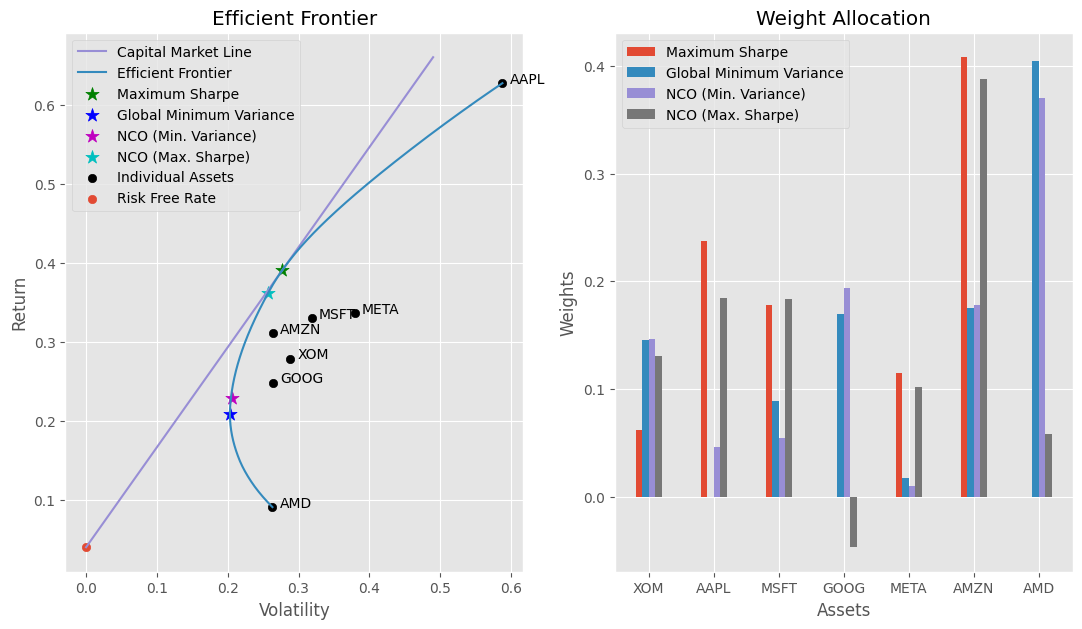

In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

# generate capital market line
x_r = np.arange(0, 0.5, 0.01)
A = np.vstack([[0, vol_t], np.ones(2)]).T
k, b = np.linalg.lstsq(A, [rf, mu_t], rcond=None)[0]
axes[0].plot(x_r, k * x_r + b, color=colors[2], label="Capital Market Line")

# generate efficient frontier plot
axes[0].plot(ef[:, 1], ef[:, 0], color=colors[1], label="Efficient Frontier")
axes[0].scatter(vol_t, mu_t, color='g', marker='*', s=100, label="Maximum Sharpe")
axes[0].scatter(vol_v, mu_v, color='b', marker='*', s=100, label="Global Minimum Variance")
axes[0].scatter(vol_nco_min_var, mu_nco_min_var, color='m', marker='*', s=100, label="NCO (Min. Variance)")
axes[0].scatter(vol_nco_sharpe, mu_nco_sharpe, color='c', marker='*', s=100, label="NCO (Max. Sharpe)")
axes[0].scatter([cov[i, i] ** 0.5 for i in range(len(tickers))], mu, color='k', label='Individual Assets')
axes[0].scatter(0, rf, color=colors[0], label="Risk Free Rate")

for i in range(len(tickers)):
    axes[0].text(cov[i, i] ** 0.5 + 0.01, mu[i], tickers[i])

axes[0].set(xlabel="Volatility", ylabel="Return", title="Efficient Frontier")
axes[0].legend()

bar_width = 0.1
x = np.arange(len(tickers))

# grouped bar chart of allocations
axes[1].bar(x - 1.5 * bar_width, tan_w, bar_width, label='Maximum Sharpe')
axes[1].bar(x - 0.5 * bar_width, min_var_w, bar_width, label='Global Minimum Variance')
axes[1].bar(x + 0.5 * bar_width, nco_min_var_w, bar_width, label='NCO (Min. Variance)')
axes[1].bar(x + 1.5 * bar_width, nco_sharpe_w, bar_width, label='NCO (Max. Sharpe)')
axes[1].set(xlabel='Assets', ylabel="Weights", title="Weight Allocation")
axes[1].set_xticks(x)
axes[1].set_xticklabels(tickers)
axes[1].legend()

plt.show()

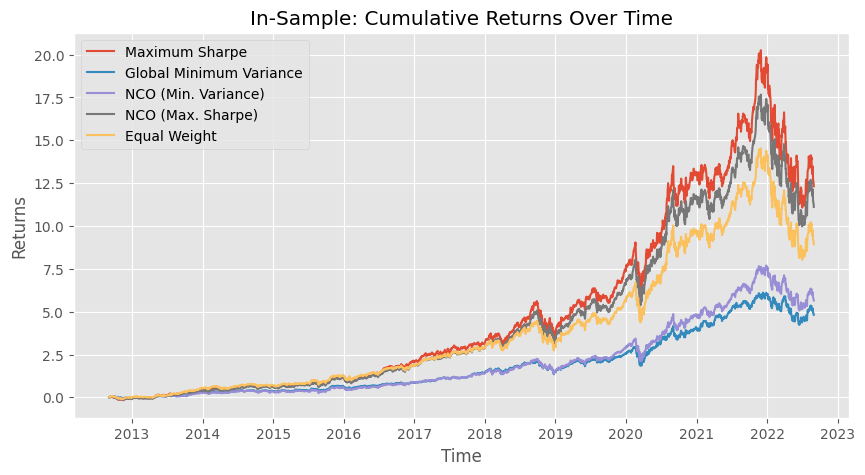

In [8]:
# in-sample test
sharpe_returns = cum_returns @ tan_w
min_var_returns = cum_returns @ min_var_w
nco_min_var_returns = cum_returns @ nco_min_var_w
nco_sharpe_returns = cum_returns @ nco_sharpe_w
equal_w_returns = cum_returns @ (np.ones(cum_returns.shape[1]) / cum_returns.shape[1])

f2, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(sharpe_returns, label="Maximum Sharpe")
ax2.plot(min_var_returns, label='Global Minimum Variance')
ax2.plot(nco_min_var_returns, label='NCO (Min. Variance)')
ax2.plot(nco_sharpe_returns, label='NCO (Max. Sharpe)')
ax2.plot(equal_w_returns, label='Equal Weight')
ax2.set(xlabel='Time', ylabel="Returns", title="In-Sample: Cumulative Returns Over Time")
ax2.legend()


plt.show()

In [9]:
# load out-of-sample data
num_years_test = 1
end_test = datetime(2023, 8, 31)
start_test = end_test - timedelta(days=365 * num_years_test)
prices_test = yf.download(tickers, start=start, end=end)['Adj Close']

[*********************100%%**********************]  7 of 7 completed


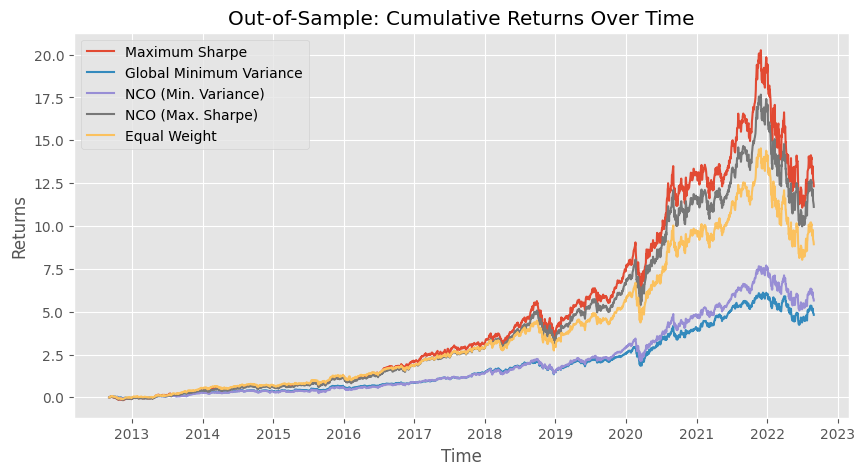

In [10]:
mu_test, cov_test, cum_returns_test = historical_returns(prices_test)

# out-of-sample test
sharpe_returns_test = cum_returns_test @ tan_w
min_var_returns_test = cum_returns_test @ min_var_w
nco_min_var_returns_test = cum_returns_test @ nco_min_var_w
nco_sharpe_returns_test = cum_returns_test @ nco_sharpe_w
equal_w_returns_test = cum_returns_test @ (np.ones(cum_returns_test.shape[1]) / cum_returns_test.shape[1])

f3, ax3 = plt.subplots(figsize=(10, 5))

ax3.plot(sharpe_returns_test, label="Maximum Sharpe")
ax3.plot(min_var_returns_test, label='Global Minimum Variance')
ax3.plot(nco_min_var_returns_test, label='NCO (Min. Variance)')
ax3.plot(nco_sharpe_returns_test, label='NCO (Max. Sharpe)')
ax3.plot(equal_w_returns_test, label='Equal Weight')
ax3.set(xlabel='Time', ylabel="Returns", title="Out-of-Sample: Cumulative Returns Over Time")
ax3.legend()

plt.show()